In [26]:
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
#https://pyramid-arima.readthedocs.io/en/latest/_submodules/arima.html
import numpy
from numpy import newaxis
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pyramid.arima import auto_arima

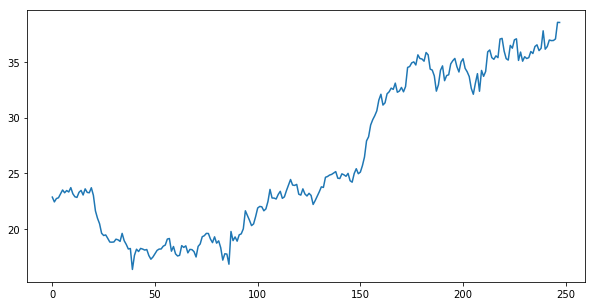

In [27]:
dataset = pandas.read_csv('URBN.csv', usecols=[1], engine='python', skipfooter=3)
dataset = numpy.flipud(dataset)[1::]
plt.figure(figsize=(10,5))
plt.plot(dataset)
plt.show()
#dataset = dataframe.values
dataset = dataset.astype('float32')

In [28]:
# fix random seed for reproducibility
#numpy.random.seed(7)

In [29]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [30]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

166 82


In [31]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [32]:
# reshape into X=t and Y=t+1
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [33]:
trainX.shape

(150, 15)

In [34]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [35]:
trainX.shape

(150, 1, 15)

In [36]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(64, input_shape=(1, look_back)))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2)

Epoch 1/200
 - 2s - loss: 0.0809
Epoch 2/200
 - 0s - loss: 0.0560
Epoch 3/200
 - 0s - loss: 0.0482
Epoch 4/200
 - 0s - loss: 0.0406
Epoch 5/200
 - 0s - loss: 0.0389
Epoch 6/200
 - 0s - loss: 0.0436
Epoch 7/200
 - 0s - loss: 0.0379
Epoch 8/200
 - 0s - loss: 0.0380
Epoch 9/200
 - 0s - loss: 0.0394
Epoch 10/200
 - 0s - loss: 0.0369
Epoch 11/200
 - 0s - loss: 0.0331
Epoch 12/200
 - 0s - loss: 0.0325
Epoch 13/200
 - 0s - loss: 0.0337
Epoch 14/200
 - 0s - loss: 0.0341
Epoch 15/200
 - 0s - loss: 0.0325
Epoch 16/200
 - 1s - loss: 0.0347
Epoch 17/200
 - 0s - loss: 0.0339
Epoch 18/200
 - 0s - loss: 0.0313
Epoch 19/200
 - 0s - loss: 0.0321
Epoch 20/200
 - 0s - loss: 0.0319
Epoch 21/200
 - 0s - loss: 0.0326
Epoch 22/200
 - 0s - loss: 0.0301
Epoch 23/200
 - 0s - loss: 0.0268
Epoch 24/200
 - 0s - loss: 0.0292
Epoch 25/200
 - 0s - loss: 0.0328
Epoch 26/200
 - 0s - loss: 0.0308
Epoch 27/200
 - 0s - loss: 0.0310
Epoch 28/200
 - 0s - loss: 0.0310
Epoch 29/200
 - 0s - loss: 0.0334
Epoch 30/200
 - 0s - lo

In [37]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.62 RMSE
Test Score: 0.83 RMSE


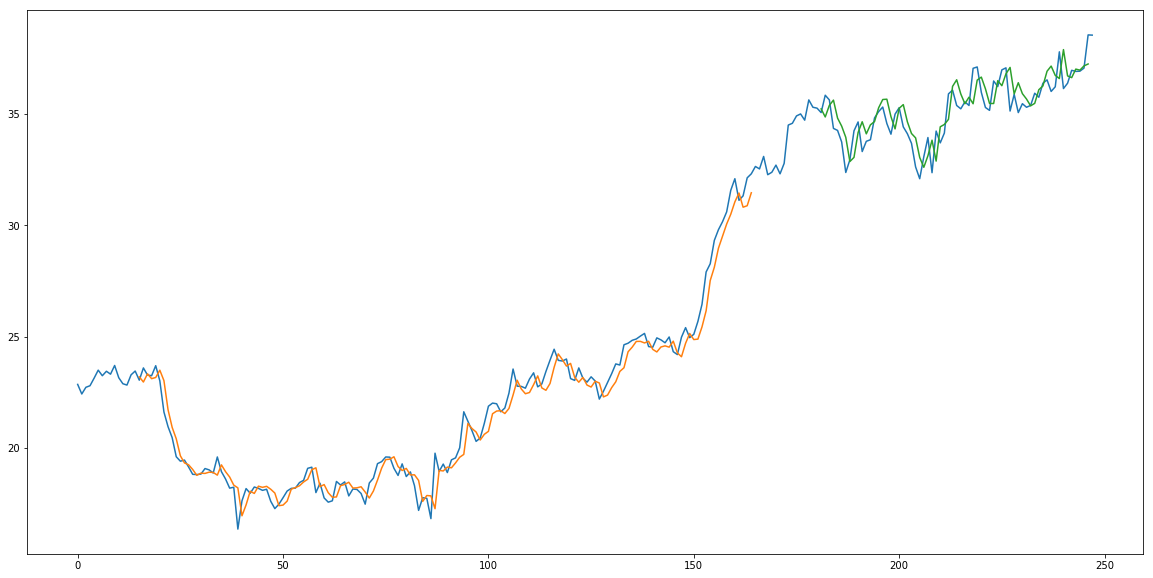

In [38]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [39]:
train2 = dataset
trainX2, trainY2 = create_dataset(train2, look_back)
trainX2 = numpy.reshape(trainX2, (trainX2.shape[0], 1, trainX2.shape[1]))
trainX2.shape, trainY2.shape

((232, 1, 15), (232,))

In [40]:
model2 = Sequential()
model2.add(LSTM(64, input_shape=(1, look_back)))
model2.add(Dropout(0.3))
model2.add(Dense(1))
model2.compile(loss='mean_absolute_error', optimizer='adam')
model2.fit(trainX2, trainY2, epochs=200, batch_size=1, verbose=2)

Epoch 1/200
 - 1s - loss: 0.1127
Epoch 2/200
 - 1s - loss: 0.0708
Epoch 3/200
 - 1s - loss: 0.0619
Epoch 4/200
 - 1s - loss: 0.0595
Epoch 5/200
 - 1s - loss: 0.0571
Epoch 6/200
 - 1s - loss: 0.0566
Epoch 7/200
 - 1s - loss: 0.0529
Epoch 8/200
 - 1s - loss: 0.0506
Epoch 9/200
 - 1s - loss: 0.0470
Epoch 10/200
 - 1s - loss: 0.0479
Epoch 11/200
 - 1s - loss: 0.0504
Epoch 12/200
 - 1s - loss: 0.0563
Epoch 13/200
 - 1s - loss: 0.0516
Epoch 14/200
 - 1s - loss: 0.0466
Epoch 15/200
 - 1s - loss: 0.0474
Epoch 16/200
 - 1s - loss: 0.0490
Epoch 17/200
 - 1s - loss: 0.0452
Epoch 18/200
 - 1s - loss: 0.0465
Epoch 19/200
 - 1s - loss: 0.0479
Epoch 20/200
 - 1s - loss: 0.0445
Epoch 21/200
 - 1s - loss: 0.0503
Epoch 22/200
 - 1s - loss: 0.0467
Epoch 23/200
 - 1s - loss: 0.0442
Epoch 24/200
 - 1s - loss: 0.0404
Epoch 25/200
 - 1s - loss: 0.0456
Epoch 26/200
 - 1s - loss: 0.0432
Epoch 27/200
 - 1s - loss: 0.0417
Epoch 28/200
 - 1s - loss: 0.0457
Epoch 29/200
 - 1s - loss: 0.0457
Epoch 30/200
 - 1s - lo

In [41]:
# make predictions
trainPredict2 = model2.predict(trainX2)
# invert predictions
trainPredict2 = scaler.inverse_transform(trainPredict2)
trainY2 = scaler.inverse_transform([trainY2])
# calculate root mean squared error
trainScore2 = math.sqrt(mean_squared_error(trainY2, trainPredict2.T))
print('Train Score2: %.2f RMSE' % (trainScore2))

Train Score2: 0.78 RMSE


In [42]:
trainY2.shape, trainPredict2.shape

((1, 232), (232, 1))

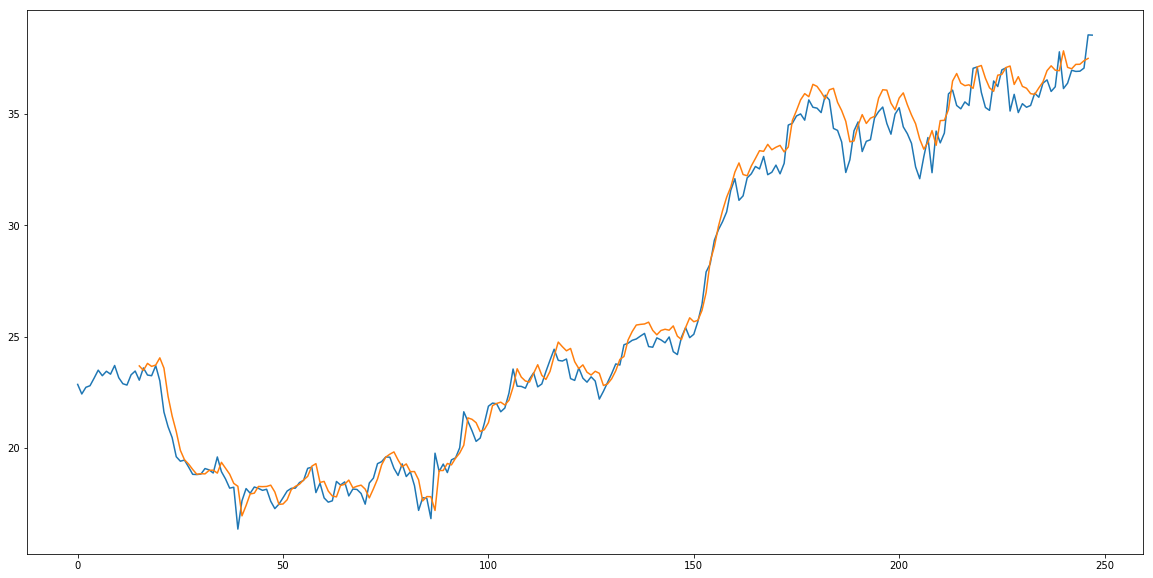

In [43]:
# shift train predictions for plotting
trainPredictPlot2 = numpy.empty_like(dataset)
trainPredictPlot2[:, :] = numpy.nan
trainPredictPlot2[look_back:len(trainPredict2)+look_back, :] = trainPredict2

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot2)
plt.show()

In [44]:
import pandas as pd
#from plotly.plotly import plot_mpl
#from statsmodels.tsa.seasonal import seasonal_decompose

In [45]:
#trainPredict2 = pd.DataFrame(trainPredict2)
#result = seasonal_decompose(trainPredict2, model='multiplicative')
#fig = result.plot()
#plot_mpl(fig)

In [46]:
numpy.savetxt("LSTM_Predicted.csv", trainPredict2, delimiter=",")

In [47]:
stepwise_model = auto_arima(trainPredict2, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=304.716, BIC=321.950, Fit time=1.324 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=375.635, BIC=389.422, Fit time=0.297 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=303.662, BIC=317.449, Fit time=0.633 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=305.618, BIC=322.852, Fit time=0.945 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=428.029, BIC=438.369, Fit time=0.200 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=305.614, BIC=322.848, Fit time=1.626 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=305.746, BIC=326.426, Fit time=2.286 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=315.584, BIC=325.924, Fit time=0.599 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 7); AIC=305.3

In [48]:
print(stepwise_model.aic())

303.661585248


In [49]:
n_periods = 30
future_forecast = stepwise_model.predict(n_periods=n_periods)
print(future_forecast)
trainPredict2full = numpy.append(trainPredict2,future_forecast)

[ 37.70564911  37.8164756   38.04750959  38.19207532  38.31546026
  38.50151136  38.63683544  38.86163478  38.97869199  39.21595669
  39.36675314  39.49636879  39.6886506   39.83020539  40.06123545
  40.18452337  40.42801879  40.58504594  40.72089231  40.91940484
  41.06719034  41.30445111  41.43396974  41.68369588  41.84695374
  41.98903082  42.19377406  42.34779028  42.59128176  42.72703111]


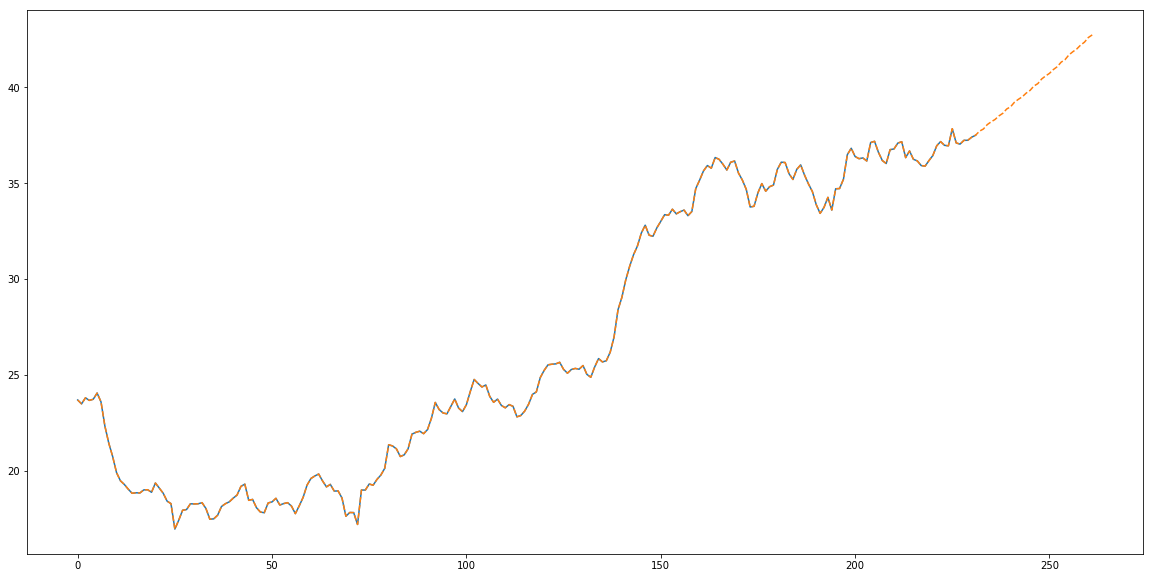

In [50]:
plt.figure(figsize=(20,10))
plt.plot(trainPredict2)
plt.plot(trainPredict2full, '--')
plt.show()